### **Prediction of Song Genre Based on Audio Features**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

from IPython.display import Image  
import pydotplus

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dataUnstructured = pd.read_csv("/content/drive/My Drive/spotify.csv")
dataUnstructured = dataUnstructured.iloc[:,1:] #The first column was just row indices, so I removed it.

In [4]:
for i in range(0,len(dataUnstructured.columns)):
    missing = [0] * len(dataUnstructured.columns)
    missing[i] = dataUnstructured.iloc[:,i].isna().sum()

pd.DataFrame({"Column":dataUnstructured.columns,"# of Missing Rows":missing}) 

,Column,# of Missing Rows
0,album,0
1,artist,0
2,genre,0
3,track_name,0
4,acousticness,0
5,danceability,0
6,duration_ms,0
7,energy,0
8,instrumentalness,0
9,key,0


In [0]:
relevant_columns=["genre","acousticness","danceability","energy","instrumentalness",
                   "liveness","loudness","speechiness","tempo","valence"]
data=dataUnstructured.loc[:,relevant_columns]
data=data[data["genre"] != "Gaming"] 

The following table shows the mean of the audio features by genre:

In [26]:
data.groupby("genre").agg("mean").round(3).reset_index()

,genre,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,Classical,0.961,0.317,0.118,0.768,0.147,-21.353,0.045,105.508,0.356
1,Country,0.169,0.562,0.706,0.004,0.183,-6.030,0.045,123.619,0.553
2,Hip Hop,0.136,0.720,0.744,0.004,0.233,-5.841,0.238,113.812,0.610
3,Jazz,0.659,0.562,0.328,0.585,0.158,-13.811,0.076,109.743,0.417
4,K-pop,0.312,0.632,0.687,0.002,0.185,-4.844,0.084,119.037,0.508
5,Pop,0.209,0.619,0.701,0.004,0.196,-5.747,0.069,121.724,0.531
6,Rock,0.103,0.502,0.753,0.039,0.183,-6.954,0.059,123.832,0.494
7,reggae,0.163,0.762,0.619,0.113,0.163,-8.213,0.127,118.844,0.738


In terms of audio features, K-Pop and Pop are very similar across the board. They will be treated as one genre.

In [0]:
data["genre"].replace({"K-pop":"Pop","reggae":"Reggae"},inplace=True)

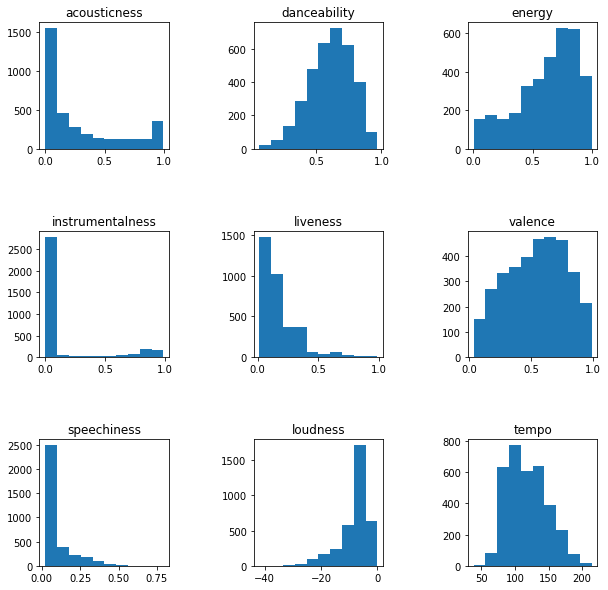

In [24]:
dummy=np.array([
    ["acousticness","danceability","energy"],
    ["instrumentalness","liveness","valence"],
    ["speechiness","loudness","tempo"]
    ])

fig,axis=plt.subplots(3,3,figsize=(10,10)) 
fig.subplots_adjust(hspace=0.65,wspace=0.65)

for i in range(0,3):
    for j in range(0,3):
        axis[i,j].set_title(dummy[i,j])

for i in range(0,3):
    for j in range(0,3):
        axis[i,j].hist(data[dummy[i,j]])

#### **Classification Tree**

In [0]:
y=data["genre"]
X=data.iloc[:,1:]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

First, a decision tree is created without varying any parameters:

In [31]:
classifier=DecisionTreeClassifier(random_state=42)
default_model=classifier.fit(X_train,y_train)
default_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [32]:
predictions=default_model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

   Classical       0.81      0.79      0.80        38
     Country       0.38      0.34      0.36        61
     Hip Hop       0.53      0.59      0.56        96
        Jazz       0.68      0.67      0.68        76
       K-pop       0.34      0.37      0.35        75
         Pop       0.43      0.40      0.42       160
        Rock       0.58      0.63      0.60        91
      reggae       0.50      0.47      0.48        94

    accuracy                           0.51       691
   macro avg       0.53      0.53      0.53       691
weighted avg       0.51      0.51      0.51       691



- **Support** is simply the observations that belong to a particular genre.
- **Accuracy** is the proportion of correct predictions out of the entire test set. In this case, the accuracy of the model is $51\%$.
- For each song genre, **precision is the proportion of true positives out of the sum of true positives and false positives**. Consider classical music with a precision of $0.81$: $81\%$ of all songs predicted to be classical music were correct,

$$ 
\frac{\text{songs correctly predicted as classical}}{\text{songs correctly predicted as classical + songs incorrectly predicted as classical}}
$$

- For each song genre, **recall is the proportion of true positives out of the sum of true positives and false negatives**. Consider classical music with a recall of $0.79$: $79\%$ of all classical music were correctly predicted as such,

$$ 
\frac{\text{songs correctly predicted as classical}}{\text{songs correctly predicted as classical + classical songs incorrectly predicted as another genre}}
$$

**In general, there is a trade-off to be made between precision and recall**.

At this point, the decision tree is still too complex for interpretability and visualization. Cost-complexicity pruning is now implemented to reduce overfitting:



In [0]:
path=classifier.cost_complexity_pruning_path(X_train,y_train) #a 2D array that contains alphas and their corresponding node impurities

ccp_alphas=path.ccp_alphas
impurities=path.impurities

Note that the last row in the path is the $\alpha$ that prunes the decision tree and leaves it with only one node, so it's always removed:

In [0]:
ccp_alphas=ccp_alphas[:-1]
impurities=impurities[:-1]

By setting $\alpha > 0$, cost-complexicity pruning  effectively decreases tree depth and node count (two measures of a decision tree's complexicity). Using a loop, multiple classification trees are created by varying $\alpha$:

In [0]:
classifiers = []
for i in ccp_alphas:
    classifier=DecisionTreeClassifier(random_state=0, ccp_alpha=i)
    classifier.fit(X_train,y_train)
    classifiers.append(classifier)

Accuracy is used to evaluate each classifier:

In [0]:
train_scores=[i.score(X_train,y_train) for i in classifiers]
test_scores=[i.score(X_test,y_test) for i in classifiers]

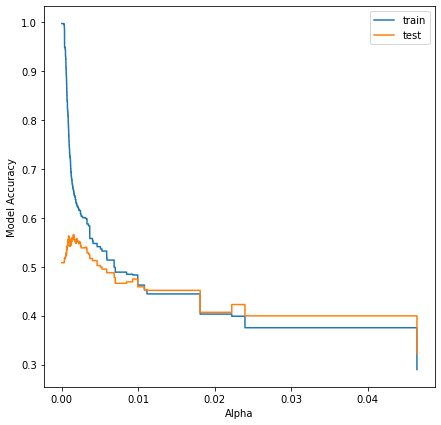

In [57]:
fig,axis=plt.subplots(figsize=(7,7))
axis.set_xlabel("Alpha")
axis.set_ylabel("Model Accuracy")
axis.plot(ccp_alphas,train_scores,label="train",drawstyle="steps-post")
axis.plot(ccp_alphas,test_scores,label="test",drawstyle="steps-post")
axis.legend()

Test accuracy is highest at around $\alpha=0.002$:

In [51]:
df=pd.DataFrame({"Test Accuracy":test_scores,"Alpha":ccp_alphas})
df["Test Accuracy"].idxmax()

481

In [52]:
df.iloc[481,:]

Test Accuracy    0.565847
Alpha            0.001550
Name: 481, dtype: float64

Setting $\alpha=0.001550$,

In [93]:
final_classifier=DecisionTreeClassifier(random_state=42,ccp_alpha=0.001550)
final_model=final_classifier.fit(X_train,y_train)
final_model

DecisionTreeClassifier(ccp_alpha=0.00155, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [94]:
predictions=final_model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

   Classical       0.86      0.84      0.85        38
     Country       0.50      0.23      0.31        61
     Hip Hop       0.63      0.67      0.65        96
        Jazz       0.76      0.79      0.77        76
       K-pop       0.37      0.43      0.40        75
         Pop       0.43      0.50      0.46       160
        Rock       0.66      0.60      0.63        91
      reggae       0.58      0.56      0.57        94

    accuracy                           0.56       691
   macro avg       0.60      0.58      0.58       691
weighted avg       0.57      0.56      0.56       691



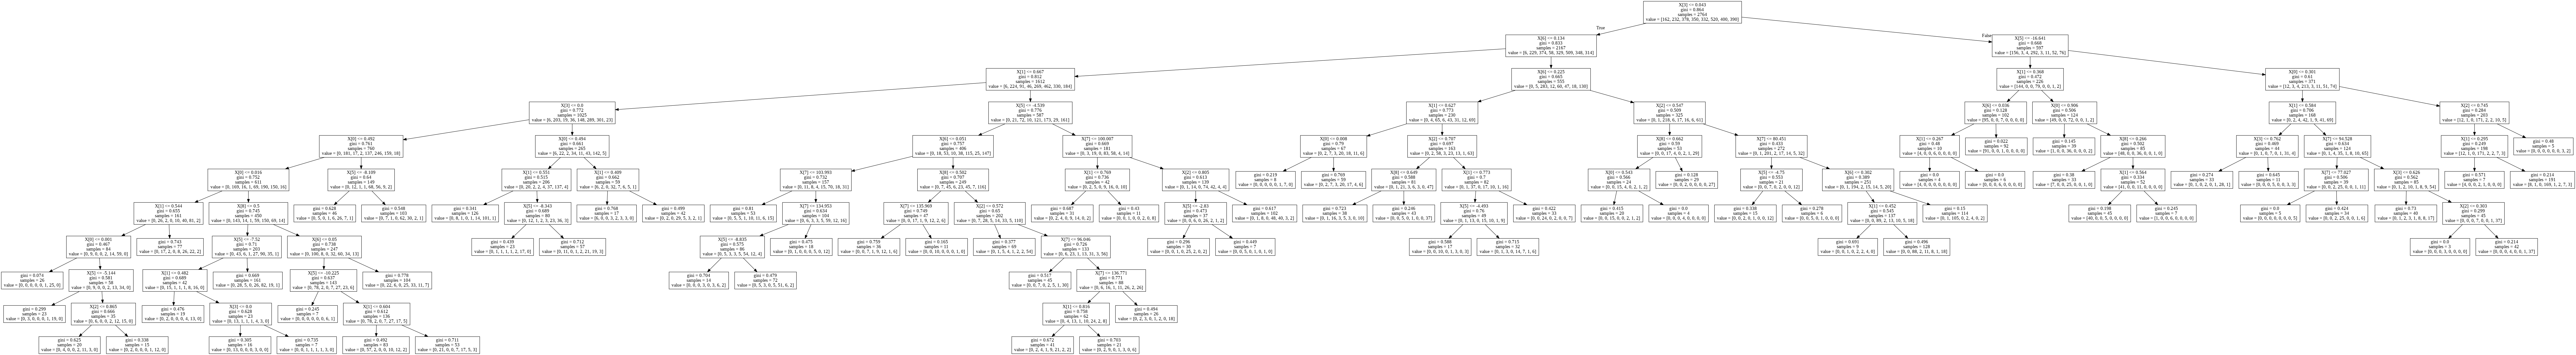

In [95]:
dot=tree.export_graphviz(final_model,out_file=None)
graph=pydotplus.graph_from_dot_data(dot)  
Image(graph.create_png())

Through cost-complexity pruning, the classification tree's accuracy increased from $51\%$ to $56\%$. However, the plot shows that the tree is still too complex. There were other parameters that could have been optimized, namely the stopping criterions:

- *max_depth*
- *min_samples_split*
- *min_samples_leaf*

Recall the concept of node purity: each node of the tree must be most of the same class as possible (in principle). Indeed, the splits at each node based on the minimum decrease in impurity can be specified. The classification trees above use the default *min_impurity_decrease* of $0$. 

In practice, a series of values for *min_impurity_decrease* are evaluated. For the sake of demonstration, let *min_impurity_decrease* $=0.01$, 

In [97]:
final_classifier=DecisionTreeClassifier(random_state=42,ccp_alpha=0.001550,min_impurity_decrease=0.01)
final_model=final_classifier.fit(X_train,y_train)
final_model
predictions=final_model.predict(X_test)
print("Accurary:",accuracy_score(y_test,predictions))

Accurary: 0.45875542691751087


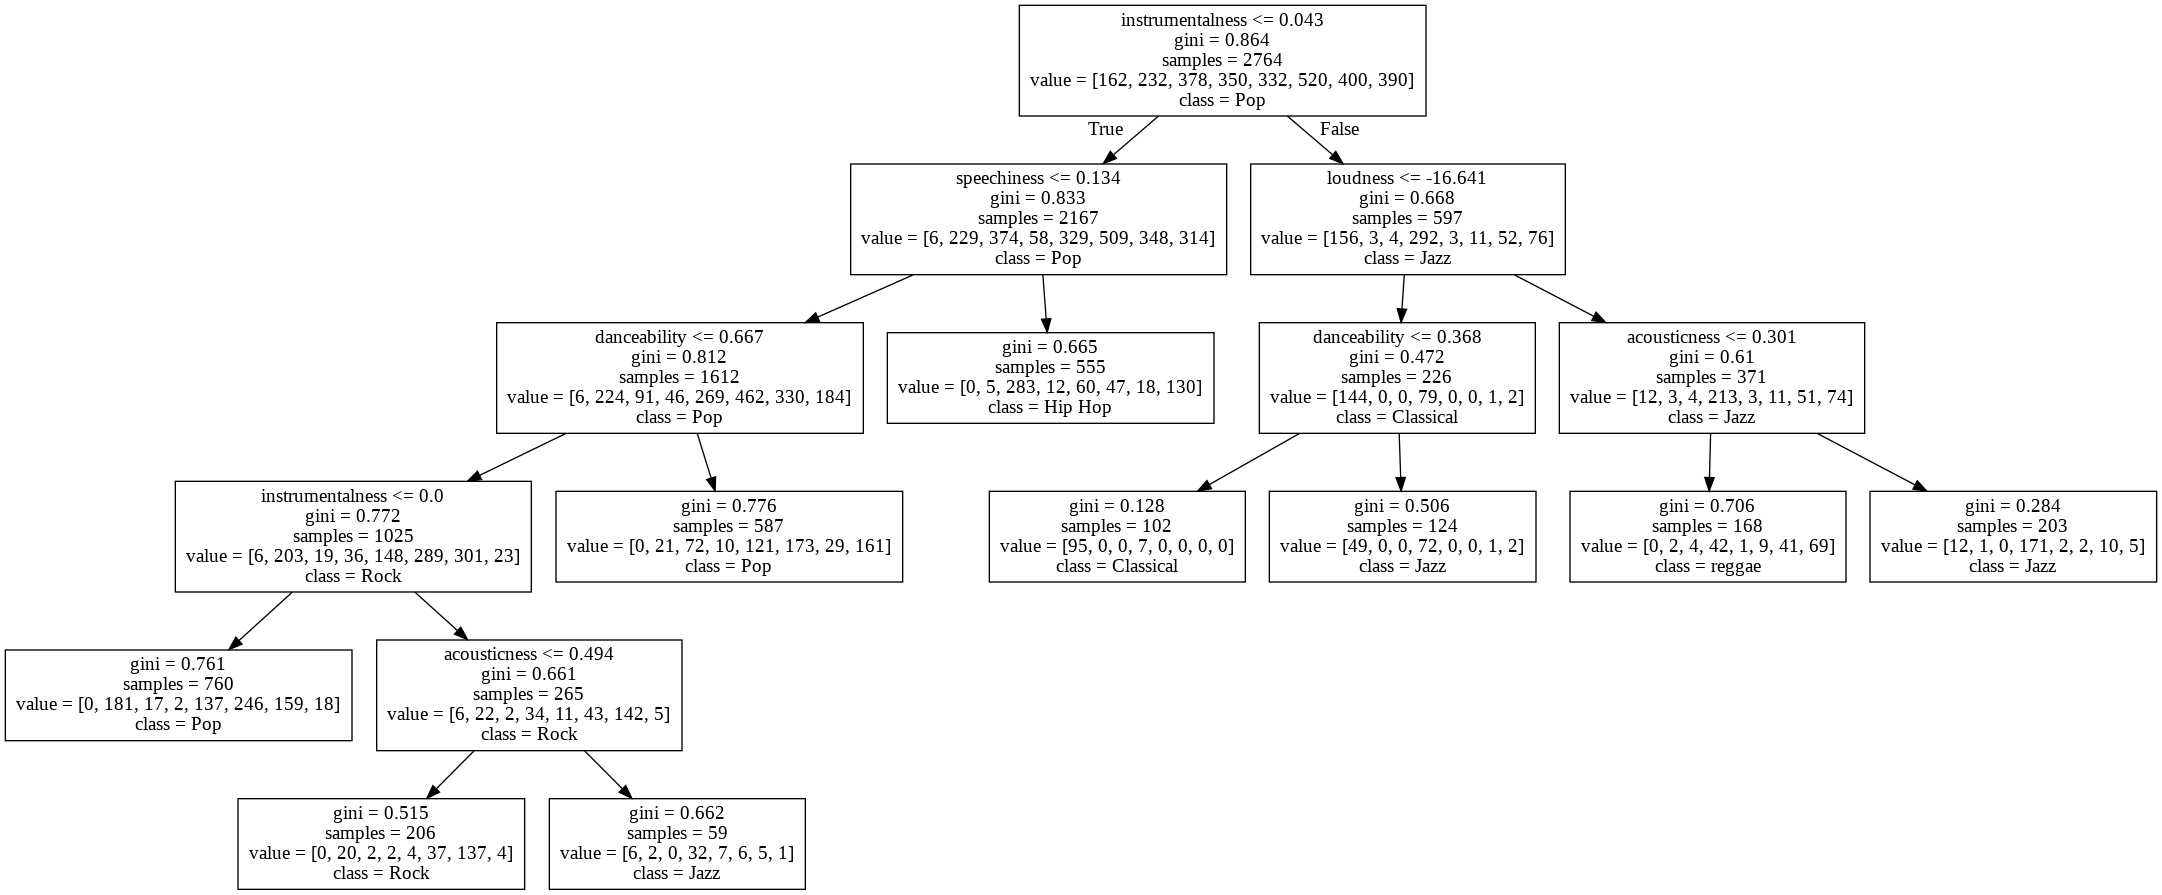

In [116]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
classes=final_model.classes_ #classes
features=data.iloc[:,1:].columns #feature names

dot=tree.export_graphviz(final_model,out_file=None,
                         class_names=classes,feature_names=features)
graph=pydotplus.graph_from_dot_data(dot)  
Image(graph.create_png())

At the expense of a decrease in accuracy from $56\%$ down to $46\%$, the decision tree becomes interpretable. But since I'm more concerned of creating a predictive model, I now turn to bagging.

#### **Bagged Classification Tree**